In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import cv2 
import numpy as np
import pandas
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras import optimizers
import keras
import pandas as pd
from keras import backend as K

In [2]:
print(os.getcwd())
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    a=(data - mu) / sigma
    a[np.isnan(a)] = 0 
    return a
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
 
def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

d:\360\output


In [3]:
inputA = Input(shape=(160,160,3))
conv1 = Conv2d_BN(inputA, 8, (3, 3))
conv1 = Conv2d_BN(conv1, 8, (3, 3))
pool1 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv1)
conv2 = Conv2d_BN(pool1, 16, (3, 3))
conv2 = Conv2d_BN(conv2, 16, (3, 3))
pool2 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv2)
conv3 = Conv2d_BN(pool2, 32, (3, 3))
conv3 = Conv2d_BN(conv3, 32, (3, 3))
pool3 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv3)
conv4 = Conv2d_BN(pool3, 64, (3, 3))
conv4 = Conv2d_BN(conv4, 64, (3, 3))
pool4 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv4)
conv5 = Conv2d_BN(pool4, 128, (3, 3))
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2d_BN(conv5, 128, (3, 3))
conv5 = Dropout(0.5)(conv5)
outputA=Model(inputA,conv5)
outputA.summary()
inputB = Input(shape=(3,132))
x=MultiHeadAttention(num_heads=2, key_dim=2,value_dim=None)(inputB,inputB)
x=Flatten()(x)
x=Dense(128)(x)
x=LeakyReLU()(x)
x=Dropout(0.5)(x)
x=Dense(1280)(x)
x=LeakyReLU()(x)
x=Dropout(0.5)(x)
x=Dense(12800)(x)
x=LeakyReLU()(x)
x=Dropout(0.5)(x)
x=Reshape((10,10,128))(x)
outputB=Model(inputB,x)
outputB.summary()
concat1 = concatenate([outputA.output, outputB.output],axis=3)
concat1 = Dropout(0.5)(concat1)
conv6 = Conv2d_BN(concat1, 64, (3, 3))
conv6 = Conv2d_BN(conv6, 64, (3, 3))
convt2 = Conv2dT_BN(conv6, 32, (3, 3),strides=(4,4))
concat2 = concatenate([conv3, convt2], axis=3)
concat2 = Dropout(0.5)(concat2)
conv7 = Conv2d_BN(concat2, 32, (3, 3))
conv7 = Conv2d_BN(conv7, 32, (3, 3))
convt3 = Conv2dT_BN(conv7, 16, (3, 3))
concat3 = concatenate([conv2, convt3], axis=3)
concat3 = Dropout(0.5)(concat3)
conv8 = Conv2d_BN(concat3, 16, (3, 3))
conv8 = Conv2d_BN(conv8, 16, (3, 3))
convt4 = Conv2dT_BN(conv8, 8, (3, 3))
concat4 = concatenate([conv1, convt4], axis=3)
concat4 = Dropout(0.5)(concat4)
conv9 = Conv2d_BN(concat4, 8, (3, 3))
conv9 = Conv2d_BN(conv9, 8, (3, 3))
conv9 = Dropout(0.5)(conv9)
outputC = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(conv9)
model = Model(inputs=[outputA.input, outputB.input], outputs=outputC)
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 160, 8)       32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 160, 160, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 8)       584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 8)       32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160, 160, 8)       0     

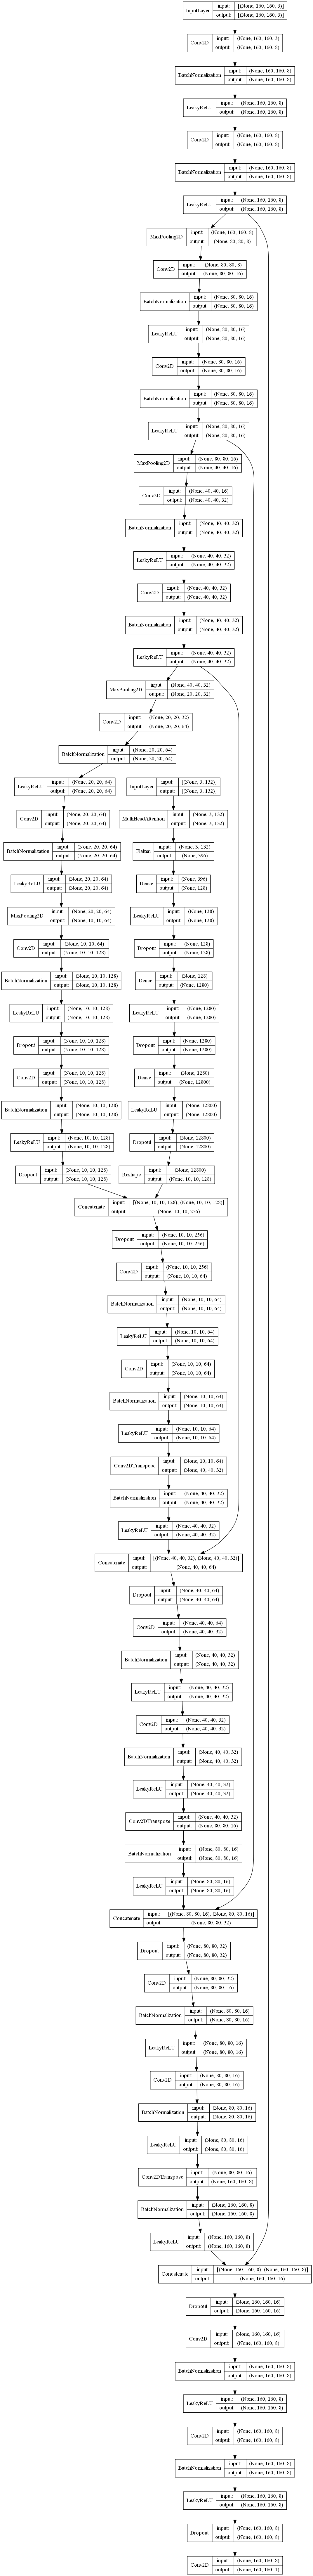

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=False)

In [12]:
class generator(keras.utils.Sequence):
    def __init__(self, image_filenames, batch_size):
        self.image_filenames = image_filenames
        self.batch_size = batch_size
    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    def __getitem__(self,idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        train_i=[]
        train_t=[]
        labels=[]
        for i in batch_x:
            img=cv2.imread("./project/rgb/"+i)
            img=cv2.resize(img,(160,160))
            img=img/255
            train_i.append(img)
            n=0
            txt=[]
            df=pd.read_csv("./project/txt/RFID_"+i[5:-4] +".txt",header=None,sep=' ')
            txt.append(df[0].tolist())
            txt.append(df[2].tolist())
            txt.append(df[4].tolist())
            train_t.append(txt)
            img=cv2.imread("./project/depth/depth"+i[5:-4]+"_trans.png",-1)
            img=cv2.resize(img,(160,160))
            img=img/(255*255)
            img=np.expand_dims(img,axis=2)
            labels.append(img)
        train_t=np.array(train_t)
        train_i=np.array(train_i)
        labels=np.array(labels)
        #print(train_t.shape)
        #print(train_i.shape)
        #print(labels.shape)
        return [train_i,train_t],labels

In [16]:
filename=os.listdir("./project/rgb/")
print(type(filename[0][0]))
print(filename)
for i in filename:
    print(i[5:-4])
df =  pd.read_csv("./project/txt/RFID_0.txt",header=None,sep=' ')
print(df[0].tolist())
print(df[2].tolist())
print(df[4].tolist())

<class 'str'>
['color0.png', 'color1.png', 'color10.png', 'color100.png', 'color101.png', 'color102.png', 'color103.png', 'color104.png', 'color105.png', 'color106.png', 'color107.png', 'color108.png', 'color109.png', 'color11.png', 'color110.png', 'color111.png', 'color112.png', 'color113.png', 'color114.png', 'color115.png', 'color116.png', 'color117.png', 'color118.png', 'color119.png', 'color12.png', 'color120.png', 'color121.png', 'color122.png', 'color123.png', 'color124.png', 'color125.png', 'color126.png', 'color127.png', 'color128.png', 'color129.png', 'color13.png', 'color130.png', 'color131.png', 'color132.png', 'color133.png', 'color134.png', 'color135.png', 'color136.png', 'color137.png', 'color138.png', 'color139.png', 'color14.png', 'color140.png', 'color141.png', 'color142.png', 'color143.png', 'color144.png', 'color145.png', 'color146.png', 'color147.png', 'color148.png', 'color149.png', 'color15.png', 'color150.png', 'color151.png', 'color152.png', 'color153.png', 'co

In [17]:
train=[]
test=[]
n=0
for i in filename:
    if(n%10!=0):
        train.append(i)
    else:
        test.append(i)
    n=n+1
print(len(train))
print(len(test))
train_load=generator(train,6)
test_load=generator(test,6)

225
26


In [8]:
model=load_model("result.h5")

In [25]:
def scheduler(epoch):
    epochs=100
    lr_epochs=200
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr * (0.1 ** (epoch // lr_epochs)))
    return K.get_value(model.optimizer.lr)
lr_new = LearningRateScheduler(scheduler)
history = model.fit(train_load,epochs = 100, shuffle=True,verbose = 1,validation_data=test_load,callbacks = [lr_new])
model.save("result.h5")

Epoch 1/100
38/38 [==============================] - 36s 790ms/step - loss: 4.4931e-06 - acc: 0.5347 - val_loss: 4.3623e-06 - val_acc: 0.5301
Epoch 2/100
38/38 [==============================] - 13s 331ms/step - loss: 4.8169e-06 - acc: 0.5347 - val_loss: 1.5394e-05 - val_acc: 0.5301
Epoch 3/100
38/38 [==============================] - 13s 331ms/step - loss: 4.5951e-06 - acc: 0.5347 - val_loss: 4.9523e-06 - val_acc: 0.5301
Epoch 4/100
38/38 [==============================] - 13s 332ms/step - loss: 4.4906e-06 - acc: 0.5347 - val_loss: 5.0295e-06 - val_acc: 0.5301
Epoch 5/100
38/38 [==============================] - 13s 335ms/step - loss: 4.6867e-06 - acc: 0.5347 - val_loss: 4.4455e-06 - val_acc: 0.5301
Epoch 6/100
38/38 [==============================] - 13s 339ms/step - loss: 4.4626e-06 - acc: 0.5347 - val_loss: 4.2648e-06 - val_acc: 0.5301
Epoch 7/100
38/38 [==============================] - 13s 331ms/step - loss: 4.4252e-06 - acc: 0.5347 - val_loss: 4.5887e-06 - val_acc: 0.5301
Epoch 

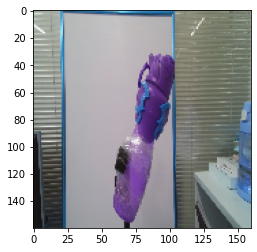

(160, 160)


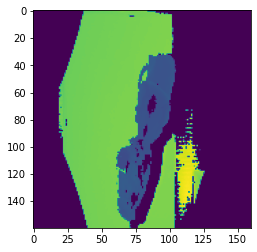

(1, 160, 160, 3)
(3, 132, 1)


In [7]:
image=[]
img=cv2.imread("./project/rgb/color0.png")
img=cv2.resize(img,(160,160))
img=img/255
image.append(img)
plt.imshow(img)
plt.show()
txt=[]
df=pd.read_csv("./project/txt/RFID_0.txt",header=None,sep=' ')
txt.append(df[0].tolist())
txt.append(df[2].tolist())
txt.append(df[4].tolist())
imgd=cv2.imread("./project/depth/depth0_trans.png",-1)
imgd=cv2.resize(imgd,(160,160))
print(imgd.shape)
imgd=imgd/(255*255)
plt.imshow(imgd)
plt.show()
image=np.array(image)
txt=np.array(txt)
txt=np.expand_dims(txt,axis=2)
print(image.shape)
print(txt.shape)

(1, 160, 160, 1)
(160, 160)


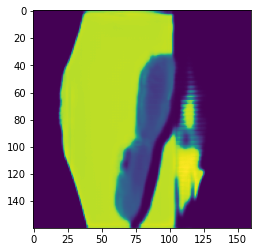

In [10]:
txt=txt.reshape(1,3,132)
res=model.predict([image,txt])
print(res.shape)
res=np.squeeze(res)
print(res.shape)
plt.imshow(res)
plt.show()